### Env Configurations

#### installing Selenium and Selenium_stealth

In [31]:
%%capture
%%shell
# Add debian buster
cat > /etc/apt/sources.list.d/debian.list <<'EOF'
deb [arch=amd64 signed-by=/usr/share/keyrings/debian-buster.gpg] http://deb.debian.org/debian buster main
deb [arch=amd64 signed-by=/usr/share/keyrings/debian-buster-updates.gpg] http://deb.debian.org/debian buster-updates main
deb [arch=amd64 signed-by=/usr/share/keyrings/debian-security-buster.gpg] http://deb.debian.org/debian-security buster/updates main
EOF

# Add keys
apt-key adv --keyserver keyserver.ubuntu.com --recv-keys DCC9EFBF77E11517
apt-key adv --keyserver keyserver.ubuntu.com --recv-keys 648ACFD622F3D138
apt-key adv --keyserver keyserver.ubuntu.com --recv-keys 112695A0E562B32A

apt-key export 77E11517 | gpg --dearmour -o /usr/share/keyrings/debian-buster.gpg
apt-key export 22F3D138 | gpg --dearmour -o /usr/share/keyrings/debian-buster-updates.gpg
apt-key export E562B32A | gpg --dearmour -o /usr/share/keyrings/debian-security-buster.gpg

# Prefer debian repo for chromium* packages only
# Note the double-blank lines between entries
cat > /etc/apt/preferences.d/chromium.pref << 'EOF'
Package: *
Pin: release a=eoan
Pin-Priority: 500


Package: *
Pin: origin "deb.debian.org"
Pin-Priority: 300


Package: chromium*
Pin: origin "deb.debian.org"
Pin-Priority: 700
EOF

# Install chromium and chromium-driver
apt-get update
apt-get install chromium chromium-driver

# Install selenium
pip install selenium
# Install selenium-stealth
pip install selenium-stealth


#### Import Necessary Libs

In [32]:
# Import Libs
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.common.by import By
from selenium.webdriver.common.action_chains import ActionChains
from google.colab import drive
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.chrome.options import Options
from selenium_stealth import stealth
import time
from selenium.webdriver import ActionChains
from selenium.webdriver.common.actions.action_builder import ActionBuilder
from selenium.webdriver.common.actions.mouse_button import MouseButton
from selenium.webdriver.common.by import By

#### Mount Google Drive

In [33]:
# Mount Google Drive
drive.mount('/content/gdrive')
# Create a folder in Colab it does not exist. The Purpose for the folder is to save scrapped html and screenshot by Selemiun
import os
directory = '/content/gdrive/MyDrive/MiniProject1'
if os.path.exists(directory):
    print("Folder already exists")
else:
    os.makedirs(directory)
    print("Folder created successfully")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
Folder already exists


#### Config Selenium and Selenium_steealth

In [34]:
# Set the Chromedriver path
chromedriver_path = '/usr/bin/chromedriver'

# create a ChromeOptions object
options = webdriver.ChromeOptions()

#run in headless mode
options.add_argument("--headless")

# disable the AutomationControlled feature of Blink rendering engine
options.add_argument('--disable-blink-features=AutomationControlled')

# disable pop-up blocking
options.add_argument('--disable-popup-blocking')

# start the browser window in maximized mode
options.add_argument('--start-maximized')

# disable extensions
options.add_argument('--disable-extensions')

# disable sandbox mode
options.add_argument('--no-sandbox')

# disable shared memory usage
options.add_argument('--disable-dev-shm-usage')

# Start the Chrome driver
driver = webdriver.Chrome(service=Service(executable_path=chromedriver_path), options=options)

# Change the property value of the navigator for webdriver to undefined
driver.execute_script("Object.defineProperty(navigator, 'webdriver', {get: () => undefined})")

In [35]:
import random

user_agents = [
    # build up some agents
	'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/109.0.0.0 Safari/537.36',
    'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/109.0.0.0 Safari/537.36',
    'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/108.0.0.0 Safari/537.36',
    'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/108.0.0.0 Safari/537.36',
    'Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/108.0.0.0 Safari/537.36',
    'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/605.1.15 (KHTML, like Gecko) Version/16.1 Safari/605.1.15',
    'Mozilla/5.0 (Macintosh; Intel Mac OS X 13_1) AppleWebKit/605.1.15 (KHTML, like Gecko) Version/16.1 Safari/605.1.15',
]
# choose a random agent and add it to the option
user_agent = random.choice(user_agents)
options.add_argument(f'user-agent={user_agent}')

### Web scrapping using selenium stealth
#### Scrap flights from Helsinki to Paris on 15th Nov., 2023
#### Scrap from Momondo
#### It takes more than 10 minutes. If less than 2 mins or scraping fails, Please run again. The User Agent will be randomed again

In [36]:
#initialize the Chrome driver with the specified options and the Service module
driver = webdriver.Chrome(service=Service(executable_path=chromedriver_path), options=options)
#enable the Stealth mode by applying the stealth function
stealth(driver,
        languages=["en-US", "en"],
        vendor="Google Inc.",
        platform="Win32",
        webgl_vendor="Intel Inc.",
        renderer="Intel Iris OpenGL Engine",
        fix_hairline=True,
        )
#navigate to the target site
driver.get("https://www.momondo.com/flight-search/HEL-PAR/2023-11-15?sort=bestflight_a")

# Wait for page to load
time.sleep(5)
while driver.execute_script("return document.readyState") != "complete":
    pass

# scroll to the bottom of the page
driver.execute_script("window.scrollBy(0, document.body.scrollHeight || document.documentElement.scrollHeight)", "")

# click show more button until it disappears, i.e., load all flight data
while True:
  try:
    clickable = driver.find_element(By.CSS_SELECTOR, 'div.ULvh-button.show-more-button')
    webdriver.ActionChains(driver)\
            .click(clickable)\
            .perform()
    time.sleep(5)
  except:
    break

# print(len(driver.find_elements(By.CSS_SELECTOR, 'div.nrc6-wrapper')))

# click details button to load all data for each flight
for i in driver.find_elements(By.CSS_SELECTOR, 'div.nrc6-wrapper'):
  try:
    clickable = i
    webdriver.ActionChains(driver)\
            .click(clickable)\
            .perform()
    time.sleep(1)
  except:
    break

# Take screenshot
driver.save_screenshot("/content/gdrive/My Drive/MiniProject1/momondo.png")

# save the html to file

with open('/content/gdrive/My Drive/MiniProject1/momondo_source.html', 'w') as f:

 f.write(driver.page_source)

# Close browser
driver.quit()

### Web scrapping using selenium stealth
#### Scrap flights from Helsinki to Paris on 15th Nov., 2023
#### Scrap from Expedia


In [37]:
# The tricky thing here is that randomizing different user agents will lead
# to different HTML layout which will completely change all HTML elements, I will mentioned it in the report.
# But anyway, here I dedicated to use the following agent. This will not happen for Momondo and Kayak however.
user_agent = 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/109.0.0.0 Safari/537.36'
options.add_argument(f'user-agent={user_agent}')

#initialize the Chrome driver with the specified options and the Service module
driver = webdriver.Chrome(service=Service(executable_path=chromedriver_path), options=options)
#enable the Stealth mode by applying the stealth function
stealth(driver,
        languages=["en-US", "en"],
        vendor="Google Inc.",
        platform="Win32",
        webgl_vendor="Intel Inc.",
        renderer="Intel Iris OpenGL Engine",
        fix_hairline=True,
        )
#navigate to the target site
driver.get("https://www.expedia.com/Flights-Search?flight-type=on&mode=search&trip=oneway&leg1=from:Helsinki,%20Finland%20(HEL-Vantaa),to:Paris%20(and%20vicinity),%20France,departure:11/15/2023TANYT&options=cabinclass:economy&fromDate=11/15/2023&d1=2023-11-15&passengers=adults:1,infantinlap:N")

# Wait for page to load
time.sleep(5)
while driver.execute_script("return document.readyState") != "complete":
    pass

# scroll to the bottom of the page
driver.execute_script("window.scrollBy(0, document.body.scrollHeight || document.documentElement.scrollHeight)", "")

# Wait for page to load
time.sleep(5)
while driver.execute_script("return document.readyState") != "complete":
    pass

# click show more button until it disappears, i.e., load all flight data
while True:
  try:
    clickable = driver.find_element(By.CSS_SELECTOR, 'button.uitk-button.uitk-button-medium.uitk-button-has-text.uitk-button-primary')
    webdriver.ActionChains(driver)\
            .click(clickable)\
            .perform()
    time.sleep(5)
  except:
    break

# click details button to load all data for each flight
# for i in range(2):
#   try:
#     # driver.find_elements
#     clickable = driver.find_element(By.CLASS_NAME, 'nrc6-inner')
#     print(clickable.text)
#     print(clickable.tag_name)
#     webdriver.ActionChains(driver)\
#             .click(clickable)\
#             .perform()
#     time.sleep(3)
#   except:
#     break

# Take screenshot
driver.save_screenshot("/content/gdrive/My Drive/MiniProject1/expedia.png")

# save the html to file

with open('/content/gdrive/My Drive/MiniProject1/expedia_source.html', 'w') as f:

 f.write(driver.page_source)

# Close browser
driver.quit()

### Web scrapping using selenium stealth
#### Scrap flights from Helsinki to Paris on 15th Nov., 2023
#### Scrap from Kayak
#### It takes more than 10 minutes. If less than 2 mins or scraping fails, Please run again. The User Agent will be randomed again


In [38]:
#initialize the Chrome driver with the specified options and the Service module
driver = webdriver.Chrome(service=Service(executable_path=chromedriver_path), options=options)
#enable the Stealth mode by applying the stealth function
stealth(driver,
        languages=["en-US", "en"],
        vendor="Google Inc.",
        platform="Win32",
        webgl_vendor="Intel Inc.",
        renderer="Intel Iris OpenGL Engine",
        fix_hairline=True,
        )
#navigate to the target site
driver.get("https://www.kayak.com/flights/HEL-PAR/2023-11-15?sort=bestflight_a")

# Wait for page to load
time.sleep(5)
while driver.execute_script("return document.readyState") != "complete":
    pass

# scroll to the bottom of the page
driver.execute_script("window.scrollBy(0, document.body.scrollHeight || document.documentElement.scrollHeight)", "")

# click show more button until it disappears, i.e., load all flight data
while True:
  try:
    clickable = driver.find_element(By.CSS_SELECTOR, 'div.ULvh-button.show-more-button')
    webdriver.ActionChains(driver)\
            .click(clickable)\
            .perform()
    time.sleep(5)
  except:
    break

# click details button to load all data for each flight
for i in driver.find_elements(By.CSS_SELECTOR, 'div.nrc6-wrapper'):
  try:
    clickable = i
    webdriver.ActionChains(driver)\
            .click(clickable)\
            .perform()
    time.sleep(1)
  except:
    break

# Take screenshot
driver.save_screenshot("/content/gdrive/My Drive/MiniProject1/kayak.png")

# save the html to file

with open('/content/gdrive/My Drive/MiniProject1/kayak_source.html', 'w') as f:

 f.write(driver.page_source)

 # Close browser
driver.quit()

### DEA for aggregated data from Expedia, Momondo and Kayak



#### Installing packages, importing libs

In [39]:
# For your reference in case you want to check the link, although this DEA uses offlice HTML scrapped before
site_ref = { 'Expedia': 'https://www.expedia.com/Flights-Search?flight-type=on&mode=search&trip=oneway&leg1=from:Helsinki,%20Finland%20(HEL-Vantaa),to:Paris%20(and%20vicinity),%20France,departure:11/15/2023TANYT&options=cabinclass:economy&fromDate=11/15/2023&d1=2023-11-15&passengers=adults:1,infantinlap:N',
          'kayak' : 'https://www.kayak.com/flights/HEL-PAR/2023-11-15?sort=bestflight_a',
          'momondo':'https://www.momondo.com/flight-search/HEL-PAR/2023-11-15?sort=bestflight_a',
}

In [40]:
# install beautifulsoup4
%%capture
!pip install beautifulsoup4
# install pytimeparse
!pip install pytimeparse


In [41]:
# import packages
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
from google.colab import drive
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import ast
from collections import Counter
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from IPython.core.display import Image, display
from google.colab import drive
from bs4 import BeautifulSoup
import re
from pytimeparse import parse

#### Initialize DataFrame

In [42]:
#Define a DataFrame to store all data from four sources
#   'Price' to refer to Price
#   'No_of_Stop' to refer to Number of Stops
#   'Airline' to refer to Airline Company
#   'Departure_Time' to refer to Departure Time
#   'Arriving_Time' to refer to Arriving Time
#   'Is_Direct_Flight' to refer to Direct Flight
#   'Layover_Citys' to refer to Layover Cities
#   'Saperated_Layover_Time_in_Hours' to refer to saperated Layover Time(non direct flights)
#   'Total_Trip_Duration_in_Hours'  to refer to Trip Duration
#   'Type_of_Aircraft' to refer to Type of the aircraft
#   'Source_of_Info' to refer to Source of info
dataframe = pd.DataFrame(columns=['Price', 'No_of_Stop',
                                  'Airline', 'Departure_Time',
                                  'Arriving_Time', 'Is_Direct_Flight',
                                  'Layover_Citys', 'Saperated_Layover_Time_in_Hours',
                                  'Total_Trip_Duration_in_Hours', 'Type_of_Aircraft',
                                  'Source_of_Info'])
dataframe

,Price,No_of_Stop,Airline,Departure_Time,Arriving_Time,Is_Direct_Flight,Layover_Citys,Saperated_Layover_Time_in_Hours,Total_Trip_Duration_in_Hours,Type_of_Aircraft,Source_of_Info


#### saving data to DF from expedia

In [43]:
# parse Selenium HTML file to bs4.BeautifulSoup object
with open('/content/gdrive/My Drive/MiniProject1/expedia_source.html', 'r') as f:
    contents = f.read()
    soup = BeautifulSoup(contents, 'lxml')


In [44]:
#loop each flight and save the data into dataframe
for item in soup.find_all('div', attrs={"data-test-id": "intersection-observer"}):
    # Get price
    Price = item.find('span', attrs ={"class": 'uitk-lockup-price', 'aria-hidden':'true', 'data-stid':''}).getText()
    # Get numnber of stops, extract the right part from text using string split()
    try:
      No_of_Stop = item.find(lambda tag: tag.name == 'div'
                      and tag.get('class') == ['uitk-text', 'truncate', 'uitk-type-200', 'uitk-type-bold', 'uitk-text-default-theme', 'uitk-experimental-timeline-stops-text'])\
                      .getText().split(' ')[0]
    except:
      continue
    # Get numnber of stops == Nonstop, numnber of stops = 0
    if 'Non' in No_of_Stop:
      No_of_Stop = '0'
    # Get Airline Company
    Airline = item.find('h3', attrs ={"class": ['uitk-heading', 'uitk-heading-7', 'puitk-layout-flex-item']}).getText()
    # Get Departure_Time
    Departure_Time = item.find(lambda tag: tag.name == 'div'
                    and tag.get('class') == ['uitk-text','uitk-type-400','uitk-type-bold', 'uitk-text-default-theme','uitk-spacing','uitk-experimental-timeline-time','uitk-spacing-margin-inlineend-two','uitk-layout-flex-item'])\
                    .getText()
    # Get Arriving_Time
    Arriving_Time = item.find(lambda tag: tag.name == 'div'
                    and tag.get('class') == ['uitk-text','uitk-type-end','uitk-type-400','uitk-type-bold', 'uitk-text-default-theme','uitk-spacing','uitk-experimental-timeline-time','uitk-spacing-margin-inlinestart-two','uitk-layout-flex-item'])\
                    .getText()
    # creeate a Tag to check whether it is direct flight or not. Direct Flight = 1, Non Direct Flight = 0
    Is_Direct_Flight = (lambda Is_Direct_Flight :'1' if No_of_Stop == '0' else '0')(No_of_Stop)
    # It is possible that there is more than one Layover city, in order to unify the scale, create a list to store Layover_Citys
    Layover_Citys = []
    # It is possible that there is more than one Layover time, in order to unify the scale, create a list to store Saperated_Layover_Time_in_Hours
    Saperated_Layover_Time_in_Hours = []
    try:
      # it is possible it is a direct flight, the follwing code will throw nontype error, catch it and turn to outer except
      Text = item.find_all(lambda tag: tag.name == 'div'
                      and tag.get('class') == ['uitk-text', 'truncate', 'uitk-type-200', 'uitk-type-regular', 'uitk-text-default-theme', 'uitk-experimental-timeline-stops-text'])[1]\
                      .getText()
      try:
        # it is possible that there are only layover cities without layover time, catch it and turn to the inner except
        # Parse the xx h xx m to Hours for unifying the scale
        Saperated_Layover_Time_in_Hours.append(round(parse(Text.split(' in ')[0])/3600, 2))
        # append layover cities to the Layover_Citys list
        Layover_Citys.append(Text.split(' in ')[1])
      except:
        # Expedia cannot offer Saperated_Layover_Time if there is more than 1 layover city, so save it as []
        Saperated_Layover_Time_in_Hours = []
        # Save multiple layovers into Layover_Citys
        Layover_Citys = Text.split(',')
    except:
      Saperated_Layover_Time_in_Hours = []
      # Layover_Citys.append('')

    # get Total_Trip_Duration and parse it into Hours for unifying scale
    Total_Trip_Duration_in_Hours = round(parse(item.find(lambda tag: tag.name == 'div'
                    and tag.get('class') == ['uitk-text', 'uitk-type-center', 'uitk-type-200', 'uitk-type-bold', 'uitk-text-default-theme'])\
                    .getText())/3600, 2)
    # No information about Type_of_Aircraft
    Type_of_Aircraft = []
    # recode the source of the info.
    Source_of_Info = 'Expedia'
    # Append the new row to the dataFrame dataframe
    dataframe = dataframe.append({'Price': Price,
                    'No_of_Stop': No_of_Stop,
                    'Airline': Airline,
                    'Departure_Time': Departure_Time,
                    'Arriving_Time': Arriving_Time,
                    'Is_Direct_Flight': Is_Direct_Flight,
                    'Saperated_Layover_Time_in_Hours': Saperated_Layover_Time_in_Hours,
                    'Layover_Citys': Layover_Citys,
                    'Total_Trip_Duration_in_Hours': Total_Trip_Duration_in_Hours,
                    'Type_of_Aircraft': Type_of_Aircraft,
                    'Source_of_Info': Source_of_Info,
                    }, ignore_index=True)

#### saving data to DF from Monondo


In [45]:
# parse Selenium HTML file to bs4.BeautifulSoup object
with open('/content/gdrive/My Drive/MiniProject1/momondo_source.html', 'r') as f:
    contents = f.read()
    soup = BeautifulSoup(contents, 'lxml')

In [46]:
#loop each flight and save the data into dataframe
for item in soup.find_all('div', attrs={"class": "nrc6"}):
    # get price
    Price = item.find('div', attrs ={"class": 'f8F1-price-text'}).getText()
    # get number of stops using string split
    No_of_Stop = item.find('span', attrs ={"class": 'JWEO-stops-text'})\
                    .getText().split(' ')[0]
    # if it is nonstop, make No_of_Stop = 0
    if 'non' in No_of_Stop:
      No_of_Stop = '0'
    # get Airline info.
    Airline = item.find('div', attrs ={"class": ['c_cgF', 'c_cgF-mod-variant-default']}).getText()
    # create a temp list to save departure time and arriving time
    temp = []
    for each in item.find(lambda tag: tag.name == 'div'
                    and tag.get('class') == ['vmXl', 'vmXl-mod-variant-large'])\
                    .find_all('span'):
      temp.append(each.getText())
    Departure_Time = temp[0]
    Arriving_Time = temp[2]
    # creeate a Tag to check whether it is direct flight or not. Direct Flight = 1, Non Direct Flight = 0
    Is_Direct_Flight = (lambda Is_Direct_Flight :'1' if No_of_Stop == '0' else '0')(No_of_Stop)

    # create a temperary Text since the layover city and time can exists in several times in the HTML block
    Text = item.find(lambda tag: tag.name == 'div'
                      and tag.get('class') == ['JWEO']).find('div', attrs = {'class':['c_cgF','c_cgF-mod-variant-default']})
    # Create Saperated_Layover_Time_in_Hours and Layover_Citys as list
    Saperated_Layover_Time_in_Hours = []
    Layover_Citys = []
    # loop each span
    for each in Text.find_all('span'):
      try:
          # there is a chance a <span> do not have title(which is the right info of Saperated_Layover_Time_in_Hours), catch it and continue
          # use regex to extract Saperated_Layover_Time_in_Hours and parse it into Hours to unify the scale
          Saperated_Layover_Time_in_Hours.append(round(parse(re.search('(^.* )l', each['title'])[1])/3600,2))
          # get layover city and Append it to Layover_Citys
          Layover_Citys.append(each.getText())
      except:
          continue

    # get Total_Trip_Duration_in_Hours and parse it to Hours to unify scale
    Total_Trip_Duration_in_Hours = round(parse(item.find('div', attrs ={"class": 'xdW8'}).find(lambda tag: tag.name == 'div'
                      and tag.get('class') == ['vmXl', 'vmXl-mod-variant-default']).getText())/3600,2)
    try:
      # There is a change extra element <div class='o-C7'> does not have  <div class='X3K_-segments'>, catch it and continue
      Text = item.find(lambda tag: tag.name == 'div'
                        and tag.get('class') == ['o-C7']).find('div', attrs = {'class':['X3K_-segments']})
      # since there could be more than 1 layovers. And the aircraft is different for each flight between the layover. So create a Type_of_Aircraft to store them
      Type_of_Aircraft = []
      for each in Text.find_all('div', attrs = {'class':['nAz5']}):
        try:
            # there is a that no record for aircraft, catch it and continue
            Type_of_Aircraft.append(each.find('div', attrs = {'class':['af2q-equip-name']}).getText())
        except:
            continue
    except:
      continue
    # record the source of the info
    Source_of_Info = 'Momondo'
    # Append the new row to the dataFrame dataframe
    dataframe = dataframe.append({'Price': Price,
                    'No_of_Stop': No_of_Stop,
                    'Airline': Airline,
                    'Departure_Time': Departure_Time,
                    'Arriving_Time': Arriving_Time,
                    'Is_Direct_Flight': Is_Direct_Flight,
                    'Saperated_Layover_Time_in_Hours': Saperated_Layover_Time_in_Hours,
                    'Layover_Citys': Layover_Citys,
                    'Total_Trip_Duration_in_Hours': Total_Trip_Duration_in_Hours,
                    'Type_of_Aircraft': Type_of_Aircraft,
                    'Source_of_Info': Source_of_Info,
                    }, ignore_index=True)

#### saving data to DF from Kayak


In [47]:
# parse Selenium HTML file to bs4.BeautifulSoup object
with open('/content/gdrive/My Drive/MiniProject1/kayak_source.html', 'r') as f:
    contents = f.read()
    soup = BeautifulSoup(contents, 'lxml')

In [48]:
#loop each flight and save the data into dataframe
for item in soup.find_all('div', attrs={"class": "nrc6"}):
    # get price
    Price = item.find('div', attrs ={"class": 'f8F1-price-text'}).getText()
    # get number of stops using string split
    No_of_Stop = item.find('span', attrs ={"class": 'JWEO-stops-text'})\
                    .getText().split(' ')[0]
    # if it is nonstop, make No_of_Stop = 0
    if 'non' in No_of_Stop:
      No_of_Stop = '0'
    # get Airline info.
    Airline = item.find('div', attrs ={"class": ['c_cgF', 'c_cgF-mod-variant-default']}).getText()
    # create a temp list to save departure time and arriving time
    temp = []
    for each in item.find(lambda tag: tag.name == 'div'
                    and tag.get('class') == ['vmXl', 'vmXl-mod-variant-large'])\
                    .find_all('span'):
      temp.append(each.getText())
    Departure_Time = temp[0]
    Arriving_Time = temp[2]
    # creeate a Tag to check whether it is direct flight or not. Direct Flight = 1, Non Direct Flight = 0
    Is_Direct_Flight = (lambda Is_Direct_Flight :'1' if No_of_Stop == '0' else '0')(No_of_Stop)

    # create a temperary Text since the layover city and time can exists in several times in the HTML block
    Text = item.find(lambda tag: tag.name == 'div'
                      and tag.get('class') == ['JWEO']).find('div', attrs = {'class':['c_cgF','c_cgF-mod-variant-default']})
    # Create Saperated_Layover_Time_in_Hours and Layover_Citys as list
    Saperated_Layover_Time_in_Hours = []
    Layover_Citys = []
    # loop each span
    for each in Text.find_all('span'):
      try:
          # there is a chance a <span> do not have title(which is the right info of Saperated_Layover_Time_in_Hours), catch it and continue
          # use regex to extract Saperated_Layover_Time_in_Hours and parse it into Hours to unify the scale
          Saperated_Layover_Time_in_Hours.append(round(parse(re.search('(^.* )l', each['title'])[1])/3600,2))
          # get layover city and Append it to Layover_Citys
          Layover_Citys.append(each.getText())
      except:
          continue

    # get Total_Trip_Duration_in_Hours and parse it to Hours to unify scale
    Total_Trip_Duration_in_Hours = round(parse(item.find('div', attrs ={"class": 'xdW8'}).find(lambda tag: tag.name == 'div'
                      and tag.get('class') == ['vmXl', 'vmXl-mod-variant-default']).getText())/3600, 2)
    try:
      # There is a change extra element <div class='o-C7'> does not have  <div class='X3K_-segments'>, catch it and continue
      Text = item.find(lambda tag: tag.name == 'div'
                        and tag.get('class') == ['o-C7']).find('div', attrs = {'class':['X3K_-segments']})
      # since there could be more than 1 layovers. And the aircraft is different for each flight between the layover. So create a Type_of_Aircraft to store them
      Type_of_Aircraft = []
      for each in Text.find_all('div', attrs = {'class':['nAz5']}):
        try:
            # there is a that no record for aircraft, catch it and continue
            Type_of_Aircraft.append(each.find('div', attrs = {'class':['af2q-equip-name']}).getText())
        except:
            continue
    except:
      continue
    # record the source of the info
    Source_of_Info = 'Kayak'
    # Append the new row to the dataFrame dataframe
    dataframe = dataframe.append({'Price': Price,
                    'No_of_Stop': No_of_Stop,
                    'Airline': Airline,
                    'Departure_Time': Departure_Time,
                    'Arriving_Time': Arriving_Time,
                    'Is_Direct_Flight': Is_Direct_Flight,
                    'Saperated_Layover_Time_in_Hours': Saperated_Layover_Time_in_Hours,
                    'Layover_Citys': Layover_Citys,
                    'Total_Trip_Duration_in_Hours': Total_Trip_Duration_in_Hours,
                    'Type_of_Aircraft': Type_of_Aircraft,
                    'Source_of_Info': Source_of_Info,
                    }, ignore_index=True)
# dataframe.to_csv('/content/gdrive/My Drive/combination.csv')

#### Exploratory Data Analysis

In [56]:
dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 327 entries, 0 to 326
Data columns (total 11 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Price                            327 non-null    object 
 1   No_of_Stop                       327 non-null    object 
 2   Airline                          327 non-null    object 
 3   Departure_Time                   327 non-null    object 
 4   Arriving_Time                    327 non-null    object 
 5   Is_Direct_Flight                 327 non-null    object 
 6   Layover_Citys                    327 non-null    object 
 7   Saperated_Layover_Time_in_Hours  327 non-null    object 
 8   Total_Trip_Duration_in_Hours     327 non-null    float64
 9   Type_of_Aircraft                 327 non-null    object 
 10  Source_of_Info                   327 non-null    object 
dtypes: float64(1), object(10)
memory usage: 28.2+ KB


In [57]:
dataframe.isnull().sum()

Price                              0
No_of_Stop                         0
Airline                            0
Departure_Time                     0
Arriving_Time                      0
Is_Direct_Flight                   0
Layover_Citys                      0
Saperated_Layover_Time_in_Hours    0
Total_Trip_Duration_in_Hours       0
Type_of_Aircraft                   0
Source_of_Info                     0
dtype: int64

In [59]:
# Data pre-processing
from re import sub
from decimal import Decimal
df = dataframe.copy()
# format Price from $ xxx to int
df['Price'] = dataframe['Price'].apply(lambda x: str(Decimal(sub(r'[^\d.]','', x)))).astype(int)
# format No_of_Stop to int
df['No_of_Stop'] = dataframe['No_of_Stop'].astype(int)
# format No_of_Stop to int
df['Is_Direct_Flight'] = dataframe['Is_Direct_Flight'].astype(int)
# format Airline from string to list for further usage
df['Airline'] = dataframe['Airline'].apply(lambda x : x.split(', '))

# Save Exact Departure_Time for display purpose
df['Departure_Time_Exact'] = df['Departure_Time']
# Save Exact Arriving_Time for display purpose
df['Arriving_Time_Exact'] = df['Arriving_Time']

# format Departure_Time to standard HH:MM
df['Departure_Time'] = df['Departure_Time'].apply(lambda x: pd.to_datetime(x).strftime('%H'))
# format Arriving_Time to standard HH:MM
df['Arriving_Time'] = df['Arriving_Time'].apply(lambda x: pd.to_datetime(x).strftime('%H'))

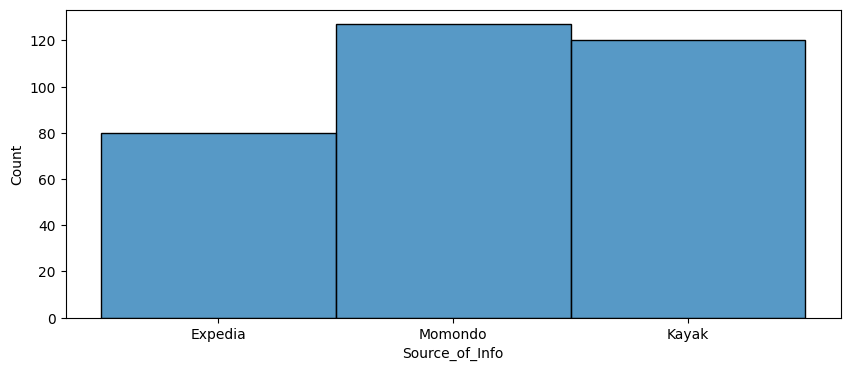

In [60]:
#plot the data records distributions for diffferent sources
# create a figure with side 10,4
plt.figure(figsize=(10,4))
# split figure to two parts
plt.subplot(1,1,1)
# plot histogram of data records distributions for diffferent sources
chart0 = sns.histplot(data=df, x='Source_of_Info')
plt.show()

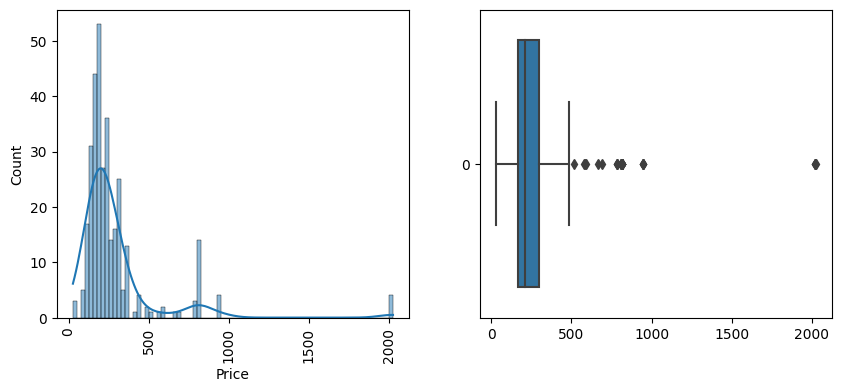

In [61]:
# create a figure with side 10,4
plt.figure(figsize=(10,4))
# split figure to two parts
plt.subplot(1,2,1)
# plot histogram of price distribution with KDE
chart1 = sns.histplot(data=df, x="Price", binwidth=25, kde = True)
chart1.set_xticklabels(chart1.get_xticklabels(), rotation=90)
# plot boxplot of price to distingish outliers
plt.subplot(1,2,2)
chart2 = sns.boxplot(df.Price, orient="h")
plt.show()

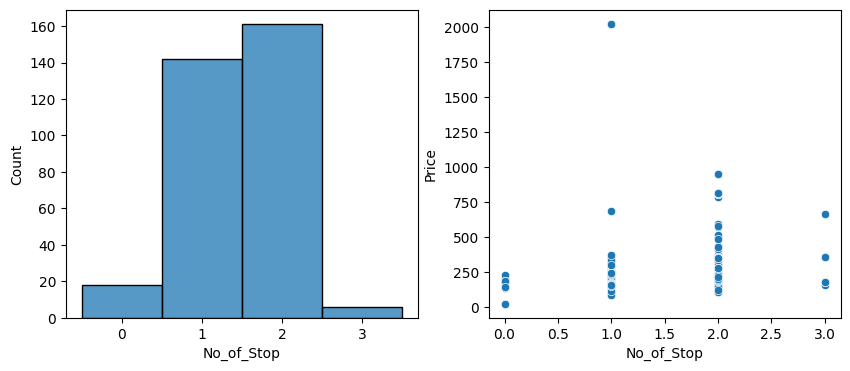

In [62]:
#plot the no. of stops frequency and see the relationshop with price
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
chart3 = sns.histplot(data=dataframe.sort_values('No_of_Stop'), x="No_of_Stop")
plt.subplot(1,2,2)
chart4 = sns.scatterplot(data=df.sort_values('No_of_Stop'), x="No_of_Stop", y="Price")
plt.show()

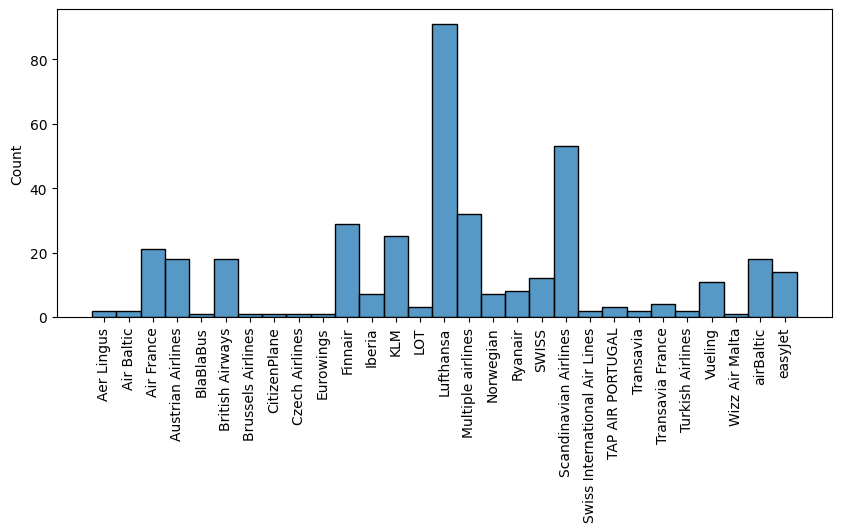

In [63]:
# plot the frequency of Airplan Company
# Flatten all records of Airline companies into a big list
Airplane_flatten = [item for sublist in df['Airline'] for item in sublist]
# Sort the list
Airplane_flatten.sort()
plt.figure(figsize=(10,4))
plt.subplot(1,1,1)
chart5 = sns.histplot(data=Airplane_flatten)
chart5.set_xticklabels(chart5.get_xticklabels(), rotation=90)
plt.show()



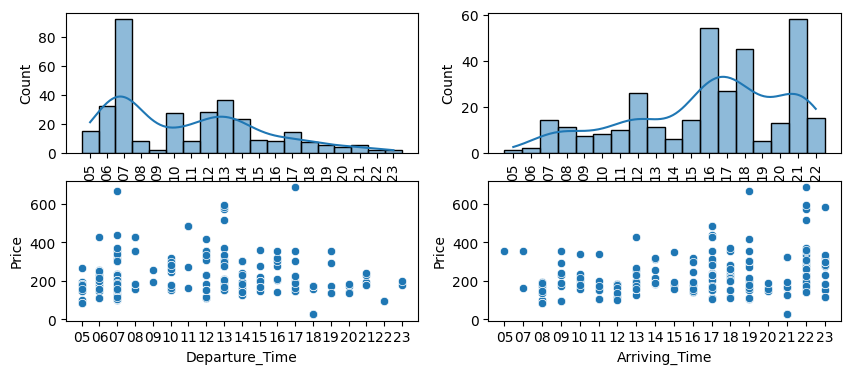

In [64]:
# plot the departure frequency in Hours
plt.figure(figsize=(10,4))
plt.subplot(2,2,1)
chart6 = sns.histplot(data=df.sort_values('Departure_Time')['Departure_Time'], kde = True)
chart6.set_xticklabels(chart6.get_xticklabels(), rotation=90)
plt.subplot(2,2,2)
chart7 = sns.histplot(data=df.sort_values('Arriving_Time')['Arriving_Time'], kde = True)
chart7.set_xticklabels(chart6.get_xticklabels(), rotation=90)

# plot the relationship betweeen price and departure time, remove some outliers in price
df_filter_price = df.where(df['Price']<700).dropna().copy()
plt.subplot(2,2,3)
chart8 = sns.scatterplot(data=df_filter_price.sort_values('Departure_Time'), x="Departure_Time", y="Price")
# plot the relationship betweeen price and arriving time, remove some outliers in price
plt.subplot(2,2,4)
chart9 = sns.scatterplot(data=df_filter_price.sort_values('Arriving_Time'), x="Arriving_Time", y="Price")
plt.show()

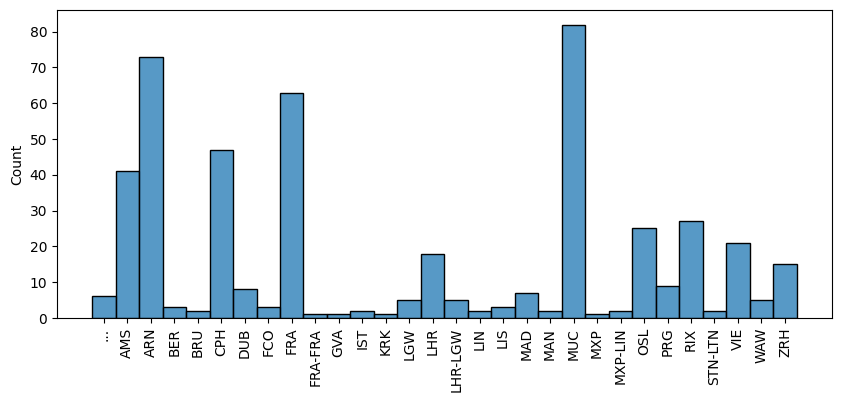

In [65]:
# plot the frequency of Layover City
# Flatten all records of Layover_Citys into a big list
Layover_Citys_flatten = [item for sublist in df['Layover_Citys'] for item in sublist]
# Strip whitespace if there is any in the list for ranking purpose
Layover_Citys_flatten = [x.strip(' ') for x in Layover_Citys_flatten]
# sort the Layover_Citys
Layover_Citys_flatten.sort()
plt.figure(figsize=(10,4))
plt.subplot(1,1,1)
chart10 = sns.histplot(data=Layover_Citys_flatten)
chart10.set_xticklabels(chart10.get_xticklabels(), rotation=90)
plt.show()

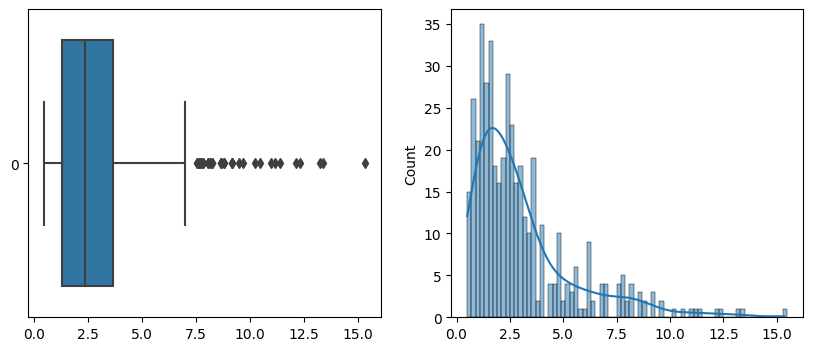

In [66]:
# plot the distribution of Layover time
# Flatten all records of Saperated_Layover_Time_in_Hours into a big list
Saperated_Layover_Time_in_Hours_flatten = [item for sublist in df['Saperated_Layover_Time_in_Hours'] for item in sublist]
# sort the list
Saperated_Layover_Time_in_Hours_flatten.sort()
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
chart11 = sns.boxplot(Saperated_Layover_Time_in_Hours_flatten, orient="h")
plt.subplot(1,2,2)
chart12 = sns.histplot(data=Saperated_Layover_Time_in_Hours_flatten, binwidth=0.2, kde = True)
plt.show()

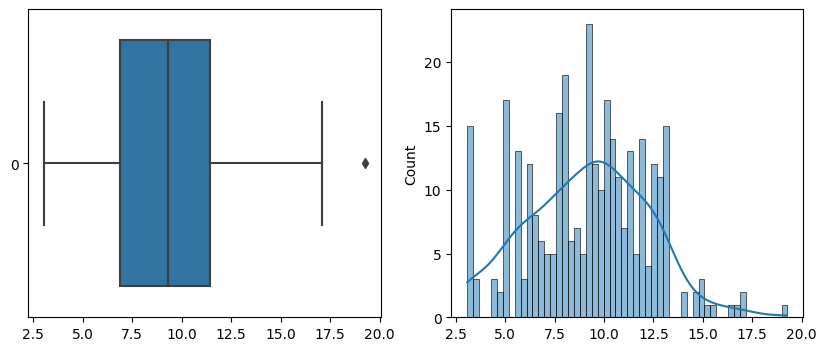

In [67]:
# plot the distribution of Total trip Duration
Total_Trip_Duration_in_Hours_flatten = df['Total_Trip_Duration_in_Hours'].to_list()
Total_Trip_Duration_in_Hours_flatten.sort()
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
chart13 = sns.boxplot(Total_Trip_Duration_in_Hours_flatten, orient="h")
plt.subplot(1,2,2)
chart14 = sns.histplot(data=Total_Trip_Duration_in_Hours_flatten, binwidth=0.3, kde = True)
plt.show()

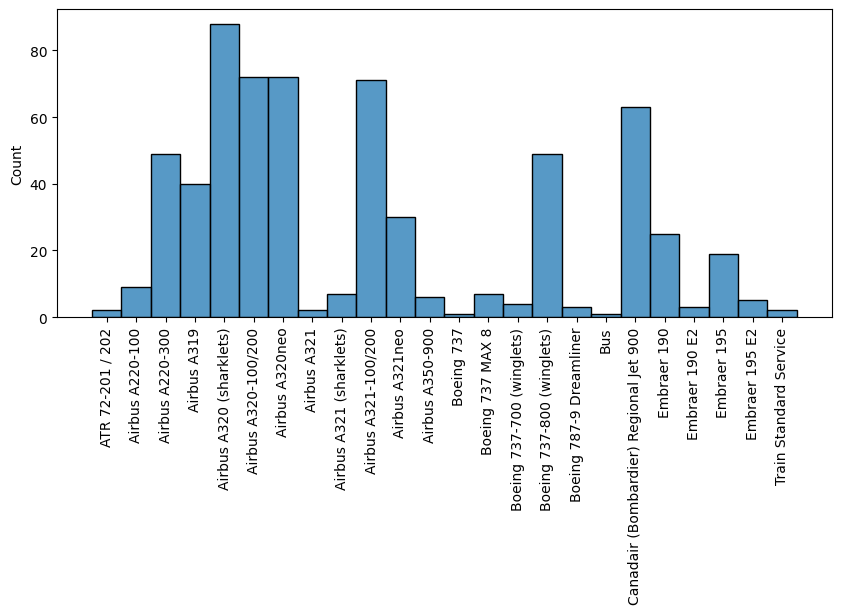

In [68]:
# plot the frequency of Airsraft Type
# Flatten all records of Type_of_Aircraft into a big list
Type_of_Aircraft_flatten = [item for sublist in df['Type_of_Aircraft'] for item in sublist]
Type_of_Aircraft_flatten.sort()
plt.figure(figsize=(10,4))
plt.subplot(1,1,1)
chart15 = sns.histplot(data=Type_of_Aircraft_flatten)
chart15.set_xticklabels(chart15.get_xticklabels(), rotation=90)
plt.show()

###Interaction with the user

In [69]:
# Data pre-processing
from re import sub
from decimal import Decimal
# copy to a new dataframe df_interactive
df_interactive = df.copy()

In [70]:
# Use interactive widgets to achieve user interaction
from ipywidgets import interact, interactive, fixed, interact_manual, Button, Layout, Layout, Box, FloatText, Textarea, Dropdown, Label, IntSlider
import ipywidgets as widgets
import random

# Data preparation, define the default values/min-max values in the widgets
price_min = min(df_interactive.Price)
price_max = max(df_interactive.Price)
Total_Trip_Duration_min = min(df_interactive.Total_Trip_Duration_in_Hours)
Total_Trip_Duration_max = max(df_interactive.Total_Trip_Duration_in_Hours)
No_of_Stop_Unique = df_interactive.No_of_Stop.unique()
No_of_Stop_Unique.sort()
No_of_Stop_Unique_List = No_of_Stop_Unique.tolist()
Airline_Companies_flatten = [item for sublist in df_interactive['Airline'] for item in sublist]
Airline_Company_Unique = np.unique(Airline_Companies_flatten)
Airline_Company_Unique.sort()
Airline_Company_Unique_List = Airline_Company_Unique.tolist()
# In case User want to see all Airline_Company, we give him this option
Airline_Company_Unique_List.insert(0, "ALL")
# In case User want to see all No_of_Stop, we give him this option
No_of_Stop_Unique_List.insert(0, "ALL")



# define the style of description for each widget to display all the long content
style = {'description_width': 'initial'}

# define the interactive widgets
@widgets.interact(
  form_item_layout = Layout(
      display='flex',
      flex_flow='row',
      justify_content='space-between'
  ),price_choice = widgets.FloatRangeSlider(
      value=[price_min, price_max],
      min=price_min,
      max=price_max,
      step=1,
      description='Price Range($):',
      disabled=False,
      continuous_update=False,
      orientation='horizontal',
      readout=True,
      readout_format='.1f',
      layout=Layout(width='50%'),
      style=style
  ),trip_duration_choice = widgets.FloatRangeSlider(
      value=[Total_Trip_Duration_min, Total_Trip_Duration_max],
      min=Total_Trip_Duration_min,
      max=Total_Trip_Duration_max,
      step=0.1,
      description='Trip Duration in Hours(e.g. 1.2):',
      disabled=False,
      continuous_update=False,
      orientation='horizontal',
      readout=True,
      readout_format='.1f',
      layout=Layout(width='50%'),
      style=style
  ),no_of_stops_choice=widgets.Dropdown(
      options=No_of_Stop_Unique_List,
      value='ALL',
      description='No. of Stops',
      disabled=False,
      layout=Layout(width='50%'),
      style=style
  ),
  max_layover_duration_choice = widgets.Text(
      value='1000',
      placeholder='total accepted layover time in Hours(e.g. 1.2)',
      description='Maximum Layover Duration in Hours(e.g. 1.2):',
      disabled=False,
      layout=Layout(width='50%'),
      style=style
  ),flight_company_choice=widgets.Dropdown(
      options=Airline_Company_Unique_List,
      value="ALL",
      description='Airline Company:',
      disabled=False,
      layout=Layout(width='50%'),
      style=style
  ),ranking = widgets.Dropdown(
      options=['Cheapest', 'Fastest'],
      value='Cheapest',
      description='Ranking Strategy:',
      disabled=False,
      layout=Layout(width='50%'),
      style=style
  ),earliest_available_time_choice = widgets.Dropdown(
      options=['00','01', '02','03', '04','05', '06','07', '08','09', '10','11', '12','13', '14','15', '16','17', '18','19', '20','21', '22','23'],
      value='08',
      description='Earliest Available Time:',
      disabled=False,
      layout=Layout(width='50%'),
      style=style
  )
)


# Define the call back function
def f(price_choice, trip_duration_choice, no_of_stops_choice, max_layover_duration_choice, flight_company_choice, ranking, earliest_available_time_choice):
  # define a print_result function for the formatted content
  def print_result(result, ranking):
    # Catch the no record exception and print no record alert
    try:
      # get the first row to extract data
      price = result.iloc[0]['Price']
      trip_duration = result.iloc[0]['Total_Trip_Duration_in_Hours']
      layover_cities = result.iloc[0]['Layover_Citys']
      layover_times = result.iloc[0]['Saperated_Layover_Time_in_Hours']
      aircraft_type = result.iloc[0]['Type_of_Aircraft']
      departure_time = result.iloc[0]['Departure_Time_Exact']
      arriving_time = result.iloc[0]['Arriving_Time_Exact']
      airline_company = result.iloc[0]['Airline']
      source = result.iloc[0]['Source_of_Info']
      # turn flag 'Is_Direct_Flight' to Yes or No
      if result.iloc[0]['Is_Direct_Flight'] == '1' :
        is_direct_flight = 'Yes'
      else:
        is_direct_flight = 'No'

      # print formatted info. out
      print('''\n\n\nBased on your selection, the {0} flight is: \n
          Price in Dollar: {1} \n
          Total Duration in Hours : {2} \n
          Is it a direct flight? : {3} \n
          Layover Cities: {4} \n
          Layover time(Hours) in each city: {5} \n
          Type of Aircraft for each trip : {6} \n
          Departure time at : {7} \n
          Departure time at : {8} \n
          Airline company for each flight : {9} \n
          Source of Info. : {10} \n
          '''
          .format((ranking),(price),(trip_duration),(is_direct_flight),(layover_cities),(layover_times),(aircraft_type),(departure_time),(arriving_time),(airline_company),(source))
      )
    except:
      print('\n\n\nNo Record, try to expand your selection criterion \n')

  # instantly get the user inputs from widgets, and upadte the results through interactive widget, and print it out
  price_min, price_max = price_choice
  trip_duration_min, trip_duration_max = trip_duration_choice
  no_of_stops = no_of_stops_choice
  max_layover_duration = max_layover_duration_choice
  flight_company = flight_company_choice
  ranking = ranking
  earliest_available_time = earliest_available_time_choice
  # add Total_Layover_Time_in_Hours colume for filtering purpose
  df_interactive['Total_Layover_Time_in_Hours'] =  df_interactive['Saperated_Layover_Time_in_Hours'].apply(lambda x: sum(x))
  # if user do not give default duration for max_layover_duration, set it to 1000 to say that there is no consideration for limiting the layover time
  if max_layover_duration == '':
    max_layover_duration = '1000'
  #  Preparing the cast
  if flight_company == 'ALL':
    if no_of_stops == 'ALL':
      # Display results for all company and all no. of stops
      df_cast = ((df_interactive.Price<=price_max) & (df_interactive.Price>=price_min) & (df_interactive.Departure_Time >= earliest_available_time) &
                (df_interactive.Total_Trip_Duration_in_Hours >= trip_duration_min) & (df_interactive.Total_Trip_Duration_in_Hours <= trip_duration_max) &
                (df_interactive.Total_Layover_Time_in_Hours <= float(max_layover_duration))
      )
    else:
      # Display results for all company and specific no. of stops
      df_cast = (
               (df_interactive.Price<=price_max) & (df_interactive.Price>=price_min) &
               (df_interactive.No_of_Stop == no_of_stops) & (df_interactive.Departure_Time >= earliest_available_time) &
               (df_interactive.Total_Trip_Duration_in_Hours >= trip_duration_min) & (df_interactive.Total_Trip_Duration_in_Hours <= trip_duration_max) &
               (df_interactive.Total_Layover_Time_in_Hours <= float(max_layover_duration))
                )
  else:
    if no_of_stops == 'ALL':
      # Display results for specific company and all no. of stops
      df_cast = (
              (df_interactive.Price<=price_max) & (df_interactive.Price>=price_min) &
              (df_interactive.Airline.apply(lambda x: flight_company in x)) & (df_interactive.Departure_Time >= earliest_available_time) &
              (df_interactive.Total_Trip_Duration_in_Hours >= trip_duration_min) & (df_interactive.Total_Trip_Duration_in_Hours <= trip_duration_max) &
              (df_interactive.Total_Layover_Time_in_Hours<= float(max_layover_duration))
              )
    else:
      # Display results for specific company and specific no. of stops
      df_cast = (
                (df_interactive.Price<=price_max) & (df_interactive.Price>=price_min) &
                (df_interactive.No_of_Stop == no_of_stops) &
                (df_interactive.Airline.apply(lambda x: flight_company in x)) & (df_interactive.Departure_Time >= earliest_available_time) &
                (df_interactive.Total_Trip_Duration_in_Hours >= trip_duration_min) & (df_interactive.Total_Trip_Duration_in_Hours <= trip_duration_max) &
                (df_interactive.Total_Layover_Time_in_Hours<= float(max_layover_duration))
                )

  # use the cast to get the result
  result = df_interactive[df_cast]
  # sort the result based on the ranking strategy
  if ranking == 'Cheapest':
    # rank the result first by price and then by trip duration
    result.sort_values(['Price','Total_Trip_Duration_in_Hours'] ,inplace=True, ascending = [True, True])
  else:
    # rank the result first by  trip duration and then by price
    result.sort_values(['Total_Trip_Duration_in_Hours', 'Price'],inplace=True, ascending = [True, True])

  # Print the most cheapest/fastest flight based on user's choice
  print_result(result, ranking)
  # Instantly update result in the format of dataframe
  return result


interactive(children=(FloatRangeSlider(value=(27.0, 2026.0), continuous_update=False, description='Price Range…